In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
from pprint import pprint

In [3]:
import numpy as np
import decimal
import copy

In [4]:
import time

In [5]:
import streamm

In this getting started example we will calculate the coupling between P3HT oligomers

In [6]:
import logging
logging.basicConfig(filename='p3ht_et.log',level=logging.DEBUG)

Now let's create project and resource to keep track of our work

In [7]:
p3ht_et = streamm.Project('P3HT_ET')

In [ ]:
p3ht_et.load_json()

In [8]:
for calc_i in p3ht_et.calculations.iteritems():
    print calc_i

And a resource object to keep track of where our files are 

In [9]:
res_local = streamm.Resource('local')

Update relative location of templates directory 

In [10]:
res_local.dir['templates'] =  os.path.join(res_local.dir['home'],'..','templates','')

In [11]:
res_local.make_dir()

In [12]:
p3ht_et.set_resource(res_local)

Now we need to set a remote resource we have ssh access to and run calculations 

In [13]:
peregrine = streamm.Resource('peregrine')

In [14]:
peregrine.meta['type'] = "ssh"
peregrine.ssh['username'] = "tkemper"    
peregrine.ssh['address'] = "peregrine.hpc.nrel.gov"    
peregrine.dir['storage'] = '/mss/users/%s'%(peregrine.ssh['username'])
peregrine.dir['scratch'] = '/scratch/%s'%(peregrine.ssh['username'])
peregrine.dir['home'] = res_local.dir['home']
peregrine.dir['launch'] = res_local.dir['launch']
peregrine.dir['templates'] = res_local.dir['templates']

# Set default simulation specs
peregrine.properties['allocation'] = 'orgopv'
peregrine.properties['e-mail'] = 'travis.kemper@nrel.gov'
peregrine.properties['scratch'] = peregrine.dir['scratch']
peregrine.properties['allocation'] = 'orgopv'
peregrine.properties['walltime'] = 4
peregrine.properties['nodes'] = int(1)
peregrine.properties['ppn'] = int(24)
peregrine.properties['nproc'] = peregrine.properties['nodes']*peregrine.properties['ppn']
peregrine.properties['queue'] = 'short'
peregrine.properties['feature'] = '24core'
peregrine.properties['exe_command'] = 'qsub '

In [15]:
pprint(peregrine.properties)

{u'allocation': 'orgopv',
 'e-mail': 'travis.kemper@nrel.gov',
 u'exe_command': 'qsub ',
 u'feature': '24core',
 u'nodes': 1,
 u'nproc': 24,
 u'pmem': 1500,
 u'ppn': 24,
 u'queue': 'short',
 'scratch': '/scratch/tkemper',
 u'walltime': 4}


In [16]:
peregrine.make_dir()

Explicitely create a thiophene molecule

In [17]:
bbTh = streamm.Buildingblock('thiophene')
symbols = ['C','C','C','C','S','H','H','H','H']
positions = [ ]
positions.append([-1.55498576,-1.91131218,-0.00081000])
positions.append([-0.17775976,-1.91131218,-0.00081000])
positions.append([0.34761524,-0.57904218,-0.00081000])
positions.append([-0.65884476,0.36101082,0.00000000])
positions.append([-2.16948076,-0.35614618,-0.00000800])
positions.append([-2.18966076,-2.79526518,-0.00132100])
positions.append([0.45389024,-2.80145418,-0.00106400])
positions.append([1.41682424,-0.35961818,-0.00138200])
positions.append([-0.51943676,1.44024682,0.00064700])
for i in range(len(symbols)):
    pt_i = streamm.Particle(symbol=symbols[i])
    pos_i = positions[i]
    bbTh.add_partpos(pt_i,pos_i)

In [18]:
bbTh.particles[5].rsite = 'termcap'
bbTh.particles[6].rsite = 'funccap'
bbTh.particles[8].rsite = 'termcap'

Set some properties of the molecule to keep track of the parts

In [19]:
c_cnt =1
h_cnt =1

for pkey_i, particle_i  in bbTh.particles.iteritems():

    if( particle_i.symbol == 'C' ):
        particle_i.label = "C%d"%(c_cnt)
        particle_i.resname = "SCP2"
        particle_i.residue = 1

        c_cnt +=1 
    if( particle_i.symbol == 'S' ):
        particle_i.resname = "ThS"
        particle_i.residue = 2

    if( particle_i.symbol == 'H' ):
        particle_i.label = "H%d"%(h_cnt)
        particle_i.resname = "HA"
        particle_i.residue = 3

        h_cnt +=1 


Set the force-field type and guess some reasonable charges 

In [20]:
for pkey_i, particle_i  in bbTh.particles.iteritems():
    if( particle_i.symbol == 'C' ):
        particle_i.paramkey = 'CA'
        particle_i.charge = -0.025
    if( particle_i.symbol == 'S' ):
        particle_i.paramkey = 'S'
        particle_i.charge = -0.3
    if( particle_i.symbol == 'H' ):
        particle_i.paramkey = 'HA'
        particle_i.charge = 0.1

Check molecule is neutral 

In [21]:
total_charge = 0.0
for pkey_i, particle_i  in bbTh.particles.iteritems():
    total_charge += particle_i.charge
print total_charge

-2.77555756156e-17


Optimize structure with NWChem

But let's put it in a function this time

In [22]:
def nw_opt(project_i,bb_i,res_i):
    '''Optimize a streamm Buildingblock object with nwchem 
    
    '''
    nwchem_i = streamm.NWChem('nw_opt_{}'.format(bb_i.tag))
    print nwchem_i.tag 
    # Add thiophene structure 
    nwchem_i.strucC = copy.deepcopy(bb_i)
    # Set calculation to run on external resource
    nwchem_i.set_resource(res_i)
    # Make the local directories 
    nwchem_i.make_dir()
    #Change to the `launch` directory
    os.chdir(nwchem_i.dir['launch'])
    # Copy over templates
    nwchem_i.cp_file('templates','run',"nwchem_peregrine.pbs",'templates','launch')
    nwchem_i.cp_file('templates','nw',"nwchem.nw",'templates','launch')
    # Read in templates files 
    nwchem_i.load_str('templates','nw')        
    nwchem_i.load_str('templates','run')
    # Set calculation properties 
    nwchem_i.properties['basis'] = '6-31g'
    nwchem_i.properties['method'] = 'UHF'
    nwchem_i.properties['charge'] = 0
    nwchem_i.properties['spin_mult'] = 1
    nwchem_i.properties['task'] = 'SCF optimize'
    nwchem_i.properties['coord'] = nwchem_i.strucC.write_coord()
    # 
    pprint(nwchem_i.properties)
    # Replace <key> with properties value 
    nwchem_i.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_i.tag))
    nwchem_i.properties['input_nw'] = nwchem_i.files['input']['nw']
    nwchem_i.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_i.tag))
    #
    nwchem_i.add_file('output','log',"%s.log"%(nwchem_i.tag))
    # Save details in .json files 
    os.chdir(nwchem_i.dir['home'])
    p3ht_et.dump_json()
    # 
    os.chdir(nwchem_i.dir['launch'])
    # 
    nwchem_i.push()
    # 
    nwchem_i.run()
    # Add calculation to project
    project_i.add_calc(nwchem_i,deepcopy = True)
    # 
    return project_i 

In [23]:
p3ht_et = nw_opt(p3ht_et,bbTh,peregrine)

nw_opt_thiophene
{u'allocation': 'orgopv',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -1.55498576      -1.91131218      -0.00081000 \n     C      -0.17775976      -1.91131218      -0.00081000 \n     C       0.34761524      -0.57904218      -0.00081000 \n     C      -0.65884476       0.36101082       0.00000000 \n     S      -2.16948076      -0.35614618      -0.00000800 \n     H      -2.18966076      -2.79526518      -0.00132100 \n     H       0.45389024      -2.80145418      -0.00106400 \n     H       1.41682424      -0.35961818      -0.00138200 \n     H      -0.51943676       1.44024682       0.00064700 \n',
 'e-mail': 'travis.kemper@nrel.gov',
 u'exe_command': 'qsub ',
 u'feature': '24core',
 u'finish_str': u'Total times  cpu:',
 u'maxiter': 100,
 u'method': 'UHF',
 u'nodes': 1,
 u'nproc': 24,
 u'pmem': 1500,
 u'ppn': 24,
 u'queue': 'short',
 'scratch': u'/scratch/tkemper/nw_opt_thiophene/'

In [24]:
nwchem_i = p3ht_et.calculations['nw_opt_thiophene']

Check status unit finished

In [25]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(30)    

In [26]:
print nwchem_i.meta['status']

finished


In [27]:
nwchem_i.analysis()

Print energies 

In [28]:
print nwchem_i.properties['alpha_energies'][10:20]
print nwchem_i.properties['energy']

[-0.4732391, -0.3475018, -0.3290008, 0.1318747, 0.2130991, 0.2315597, 0.2416684, 0.269473, 0.2970013, 0.3198832]
-551.190758152


Check that the positions of the structure have been optimized 

In [29]:
print bbTh.positions

[[ -1.55498576e+00  -1.91131218e+00  -8.10000000e-04]
 [ -1.77759760e-01  -1.91131218e+00  -8.10000000e-04]
 [  3.47615240e-01  -5.79042180e-01  -8.10000000e-04]
 [ -6.58844760e-01   3.61010820e-01   0.00000000e+00]
 [ -2.16948076e+00  -3.56146180e-01  -8.00000000e-06]
 [ -2.18966076e+00  -2.79526518e+00  -1.32100000e-03]
 [  4.53890240e-01  -2.80145418e+00  -1.06400000e-03]
 [  1.41682424e+00  -3.59618180e-01  -1.38200000e-03]
 [ -5.19436760e-01   1.44024682e+00   6.47000000e-04]]


In [30]:
print nwchem_i.strucC.positions

[[ -1.52896594e+00  -1.96224658e+00  -8.41020000e-04]
 [ -1.87314430e-01  -1.91419453e+00  -1.07971000e-03]
 [  3.42605840e-01  -5.70379860e-01  -6.18150000e-04]
 [ -6.05148070e-01   3.80472790e-01  -2.75500000e-05]
 [ -2.25056863e+00  -3.24184850e-01  -7.66000000e-06]
 [ -2.16226428e+00  -2.82016344e+00  -1.05054000e-03]
 [  4.31144530e-01  -2.78814792e+00  -1.58608000e-03]
 [  1.39111272e+00  -3.53785840e-01  -7.31500000e-04]
 [ -4.82440580e-01   1.43973761e+00   3.84210000e-04]]


Update positions with optimized geometry 

In [31]:
for pk,p in bbTh.particles.iteritems():
    bbTh.positions[pk] = nwchem_i.strucC.positions[pk]
    print pk,p.symbol,bbTh.positions[pk]

0 C [ -1.52896594e+00  -1.96224658e+00  -8.41020000e-04]
1 C [ -1.87314430e-01  -1.91419453e+00  -1.07971000e-03]
2 C [ 0.34260584 -0.57037986 -0.00061815]
3 C [ -6.05148070e-01   3.80472790e-01  -2.75500000e-05]
4 S [ -2.25056863e+00  -3.24184850e-01  -7.66000000e-06]
5 H [ -2.16226428e+00  -2.82016344e+00  -1.05054000e-03]
6 H [  4.31144530e-01  -2.78814792e+00  -1.58608000e-03]
7 H [  1.39111272e+00  -3.53785840e-01  -7.31500000e-04]
8 H [ -4.82440580e-01   1.43973761e+00   3.84210000e-04]


Store the results in a tar ball in the storage directory 

In [32]:
nwchem_i.store()

Now let us calculate the ESP charges to use in our forcefield 

Again let's make it a function

In [33]:
def nw_esp(project_i,bb_i,res_i):
    '''Calculate ESP charges of a streamm Buildingblock object with nwchem 
    
    '''
    nwchem_esp = streamm.NWChem('nw_esp_{}'.format(bb_i.tag))
    print(nwchem_esp.tag)
    # Add thiophene structure with optimized coordinates from previous calculation
    nwchem_esp.strucC = copy.deepcopy(bb_i)
    # Set calculation to run on external resource
    nwchem_esp.set_resource(res_i)
    # Add calculation to project
    project_i.add_calc(nwchem_esp)
    # Make the local directories 
    nwchem_esp.make_dir()
    # Change to the `launch` directory
    os.chdir(nwchem_esp.dir['launch'])
    #
    nwchem_esp.cp_file('templates','run',"nwchem_peregrine.pbs",'templates','launch')
    nwchem_esp.cp_file('templates','nw',"nwchem_esp.nw",'templates','launch')
    #
    nwchem_esp.load_str('templates','nw')        
    nwchem_esp.load_str('templates','run')
    # 
    nwchem_esp.properties['basis'] = '6-31g'
    nwchem_esp.properties['method'] = 'UHF'
    nwchem_esp.properties['charge'] = 0
    nwchem_esp.properties['spin_mult'] = 1
    nwchem_esp.properties['task'] = 'SCF'
    nwchem_esp.properties['coord'] = nwchem_esp.strucC.write_coord()

    pprint(nwchem_esp.properties)

    nwchem_esp.replacewrite_prop('nw','input','nw','%s.nw'%(nwchem_esp.tag))

    nwchem_esp.properties['input_nw'] = nwchem_esp.files['input']['nw']
    nwchem_esp.replacewrite_prop('run','scripts','run','%s.pbs'%(nwchem_esp.tag))

    nwchem_esp.add_file('output','log',"%s.log"%(nwchem_esp.tag))

    # Save details in .json files 

    os.chdir(nwchem_esp.dir['home'])
    project_i.dump_json()

    os.chdir(nwchem_esp.dir['launch'])
    nwchem_esp.push()
    nwchem_esp.run()
    # Add calculation to project
    project_i.add_calc(nwchem_esp,deepcopy = True)
    # 
    return project_i 
    
    

In [34]:
p3ht_et = nw_esp(p3ht_et,bbTh,peregrine)

nw_esp_thiophene
{u'allocation': 'orgopv',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -1.52896594      -1.96224658      -0.00084102 \n     C      -0.18731443      -1.91419453      -0.00107971 \n     C       0.34260584      -0.57037986      -0.00061815 \n     C      -0.60514807       0.38047279      -0.00002755 \n     S      -2.25056863      -0.32418485      -0.00000766 \n     H      -2.16226428      -2.82016344      -0.00105054 \n     H       0.43114453      -2.78814792      -0.00158608 \n     H       1.39111272      -0.35378584      -0.00073150 \n     H      -0.48244058       1.43973761       0.00038421 \n',
 'e-mail': 'travis.kemper@nrel.gov',
 u'exe_command': 'qsub ',
 u'feature': '24core',
 u'finish_str': u'Total times  cpu:',
 u'maxiter': 100,
 u'method': 'UHF',
 u'nodes': 1,
 u'nproc': 24,
 u'pmem': 1500,
 u'ppn': 24,
 u'queue': 'short',
 'scratch': u'/scratch/tkemper/nw_esp_thiophene/'

Check status until finished

In [35]:
nwchem_i = p3ht_et.calculations['nw_esp_thiophene']

In [36]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(1)    

In [37]:
p3ht_et.check()

Calculation nw_opt_thiophene has status stored
Calculation nw_esp_thiophene has status finished


In [38]:
nwchem_i.analysis()

In [39]:
total_charge = 0.0 
for pk,p in nwchem_i.strucC.particles.iteritems():
    print pk,p.symbol,p.charge
    total_charge += p.charge
print total_charge

0 C -0.085835
1 C -0.136737
2 C -0.08583
3 C -0.108845
4 S -0.117786
5 H 0.153802
6 H 0.11901
7 H 0.109154
8 H 0.153066
-1.00000000008e-06


Update the charges of the Buildingblock

In [40]:
bbTh.tag += '_HFesp'

In [41]:
for pk,p in bbTh.particles.iteritems():
    p.charge = nwchem_i.strucC.particles[pk].charge
    print pk,p.symbol,p.charge

0 C -0.085835
1 C -0.136737
2 C -0.08583
3 C -0.108845
4 S -0.117786
5 H 0.153802
6 H 0.11901
7 H 0.109154
8 H 0.153066


Store the results 

In [42]:
nwchem_i.store()

In [43]:
bbTh.bonded_nblist = bbTh.guess_nblist(0,radii_buffer=1.35)

In [44]:
bbTh.bonded_bonds()
bbTh.bonded_angles()
bbTh.bonded_dih()

Store a pickled object of the Buildingblock

In [45]:
os.chdir(res_local.dir['materials']) 
bbTh.dump_pickle()

Let us optimize the structure with the oplsaa force-field to check the parameters 

In [46]:
os.chdir(res_local.dir['home']) 

In [47]:
from pathlib2 import Path

In [48]:
need_files = ['oplsaa.pkl']
for f in need_files:
    path = Path(f)
    if not path.is_file():
        print("Need to run forcefields.ipynb")
        os.system("jupyter nbconvert --to python  forcefields.ipynb")
        os.system("python forcefields.py")

In [49]:
oplsaa = streamm.forcefields.parameters.read_pickle('oplsaa')

In [50]:
print oplsaa


    Parameters 
      LJ parameters 2 
      Bond parameters 2 
      Angle parameters 2 
      Dihedral parameters 1 
      Improper Dihedral parameters 0 



In [51]:
print oplsaa.unit_conf['energy']

kCalmol


We need to add the conjugated carbons, hydrogen and sulfur atom types 

In [52]:
import streamm.forcefields.particletype as particletype

In [53]:
import pymatgen_core.core.periodic_table as periodic_table

Set some parameters from J. Am. Chem. Soc., 1996, 118 (45), pp 11225–11236

In [54]:
CA = particletype.Particletype('CA')
HA = particletype.Particletype('HA')

In [55]:
CA.update_units(oplsaa.unit_conf)
HA.update_units(oplsaa.unit_conf)

In [56]:
CA.epsilon = 0.070 # kcal/mol
CA.sigma = 3.55 # Angstroms 

In [57]:
HA.epsilon = 0.030 # kcal/mol
HA.sigma = 2.42 # Angstroms 

In [58]:
CA.mass =  periodic_table.Element['C'].atomic_mass.real
HA.mass =  periodic_table.Element['H'].atomic_mass.real

In [59]:
print CA,HA

 CA epsilon:0.07 sigma:3.55  HA epsilon:0.03 sigma:2.42


In [60]:
S = particletype.Particletype('S')

In [61]:
S.update_units(oplsaa.unit_conf)

Set some parameters from J. Am. Chem. Soc., 1996, 118 (45), pp 11225–11236

In [62]:
S.epsilon = 0.25 # kcal/mol
S.sigma = 3.55 # Angstroms 

In [63]:
S.mass =  periodic_table.Element['S'].atomic_mass.real

Add to forcefield parameters container

In [64]:
oplsaa.add_particletype(CA)
oplsaa.add_particletype(HA)
oplsaa.add_particletype(S)

Set the bond stretching parameters 

In [65]:
import streamm.forcefields.bondtype as bondtype

In [66]:
bt_i = bondtype.Bondtype('CA','HA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.080,367.0)
oplsaa.add_bondtype(bt_i)

In [67]:
bt_i = bondtype.Bondtype('CA','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.400,469.0)
oplsaa.add_bondtype(bt_i)

In [68]:
bt_i = bondtype.Bondtype('S','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.71,250.0)
oplsaa.add_bondtype(bt_i)

In [69]:
for btk,bt in oplsaa.bondtypes.iteritems():
    print btk,bt

0  bond  CT - HC type harmonic 
  harmonic r_0 = 1.080000 K = 367.000000 lammps index 0  gromacs index 0  
1  bond  CT - CT type harmonic 
  harmonic r_0 = 1.530000 K = 268.000000 lammps index 0  gromacs index 0  
2  bond  CA - HA type harmonic 
  harmonic r_0 = 1.080000 K = 367.000000 lammps index 0  gromacs index 0  
3  bond  CA - CA type harmonic 
  harmonic r_0 = 1.400000 K = 469.000000 lammps index 0  gromacs index 0  
4  bond  S - CA type harmonic 
  harmonic r_0 = 1.710000 K = 250.000000 lammps index 0  gromacs index 0  


In [70]:
import streamm.forcefields.angletype as angletype

In [71]:
bat_i = angletype.Angletype('CA','CA','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,63.0)
oplsaa.add_angletype(bat_i)

In [72]:
bat_i = angletype.Angletype('CA','CA','HA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)

In [73]:
bat_i = angletype.Angletype('CA','S','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(92.2,70.0)
oplsaa.add_angletype(bat_i)

In [74]:
bat_i = angletype.Angletype('S','CA','HA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)

In [75]:
bat_i = angletype.Angletype('S','CA','CA',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(111.0,70.0)
oplsaa.add_angletype(bat_i)

In [76]:
for atk,at in oplsaa.angletypes.iteritems():
    print atk,at

0  angle  HC - CT - HC type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
1  angle  HC - CT - CT type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
2  angle  CA - CA - CA type harmonic 
  harmonic theta_0 = 120.000000 K = 63.000000 lammps index 0  gromacs index 0  
3  angle  CA - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
4  angle  CA - S - CA type harmonic 
  harmonic theta_0 = 92.200000 K = 70.000000 lammps index 0  gromacs index 0  
5  angle  S - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
6  angle  S - CA - CA type harmonic 
  harmonic theta_0 = 111.000000 K = 70.000000 lammps index 0  gromacs index 0  


Set some reasonable dihedral parameters

In [77]:
import streamm.forcefields.dihtype as dihtype

In [79]:
dih_i = dihtype.Dihtype('X','CA','CA','X',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,1.812532,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [80]:
dih_i = dihtype.Dihtype('X','S','CA','X',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,2.416710,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [81]:
dih_i = dihtype.Dihtype('S','CA','CA','HA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,1.812532,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [82]:
for dk,d in oplsaa.dihtypes.iteritems():
    print dk,d 

0  dihedral  HC - CT - CT - HC type opls 
  k1 = 0.000000 k2 = 0.000000 k3 = 0.300000 k4 = 0.000000 lammps index 0  gromcas index 0 
1  dihedral  X - CA - CA - X type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
2  dihedral  X - S - CA - X type opls 
  k1 = 0.000000 k2 = 2.416710 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
3  dihedral  S - CA - CA - HA type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 


Let us make an MD simulation of just the monomer to check that our parameters are okay

In [360]:
def lmp_run(project_i,bb_i,param_i,res_i,md_type = 'min'):
    # Create LAMMPS calculation object 
    calc_n =  len(project_i.calculations)     
    lmp_i = streamm.LAMMPS('lmp_{}_{}_calc_{}'.format(md_type,bb_i.tag,calc_n))
    # lmp_i = streamm.LAMMPS('lmp_{}_{}'.format(md_type,bb_i.tag))
    # Set parameter container 
    lmp_i.paramC = param_i
    lmp_i.set_strucC(bb_i)
    # Set force-field parameters 
    lmp_i.set_ffparam()
    # Set resource to local
    lmp_i.set_resource(res_i)
    # Make local directories
    lmp_i.make_dir()
    # Set pbc's to on
    lmp_i.strucC.lat.pbcs = [True,True,True]
    # Change to launch directory
    os.chdir(lmp_i.dir['launch'])
    # Copy over the templates from the template directory 
    lmp_i.cp_file('templates','in',"lammps_{}.in".format(md_type),'templates','launch')
    lmp_i.cp_file('templates','run',"lammps_peregrine.pbs",'templates','launch')
    # Change to scratch
    os.chdir(lmp_i.dir['launch'])
    # Read in template files and store them as strings in the `str` dictionary
    lmp_i.load_str('templates','in')
    lmp_i.load_str('templates','run')
    # Write LAMMPS .data file
    lmp_i.write_data()
    # Replace keys in template string with properties 
    lmp_i.replacewrite_prop('in','input','in','%s.in'%(lmp_i.tag))
    # Add the input file to the properties to be written into the run file
    lmp_i.properties['input_in'] = lmp_i.files['input']['in']
    lmp_i.replacewrite_prop('run','scripts','run','%s.pbs'%(lmp_i.tag))
    # Save json file in root directory
    os.chdir(lmp_i.dir['home'])
    lmp_i.dump_json()
    # Run bash script or submit to cluster
    lmp_i.add_file('output','log',"%s.log"%(lmp_i.tag))
    # Save details in .json files 
    os.chdir(lmp_i.dir['home'])
    project_i.dump_json()
    #
    os.chdir(lmp_i.dir['launch'])
    lmp_i.push()
    lmp_i.run()
    # Add calculation to project
    project_i.add_calc(lmp_i,deepcopy = True)
    # 
    return project_i     

In [88]:
p3ht_et = lmp_run(p3ht_et,bbTh,oplsaa,peregrine)

In [91]:
p3ht_et.check()

Calculation nw_opt_thiophene has status stored
Calculation nw_esp_thiophene has status stored
Calculation lmp_min_thiophene_HFesp has status finished


In [92]:
lmp_i = p3ht_et.calculations['lmp_min_thiophene_HFesp']

In [93]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(30)

In [94]:
lmp_i.analysis()

>  using mdrun with len 1 
 Adding thermo keys from line: Step Temp PotEng TotEng Press Volume Lx Ly Lz E_bond E_angle E_dihed E_impro E_vdwl E_coul E_long E_tail 
 
> col  0 ['0', '0', '15.561458', '15.561458', '-0.41725388', '1000000', '100', '100', '100', '7.427194', '3.7509599', '1.3385131e-08', '0', '-0.0096922366', '6.4990527', '-2.106056', '0']
1 9823u  [0.0]
> col  1 ['8', '0', '7.7390897', '7.7390897', '0.014795405', '1000000', '100', '100', '100', '0.1159939', '3.2559828', '6.2855569e-09', '0', '-0.0095402802', '6.4823882', '-2.1057349', '0']
2 9823u  [0.0, 8.0]
 Calc 0 finished 


Energy decreased and nothing exploded so that's good

In [95]:
lmp_i.store()

Read in data file positions

In [96]:
lmp_i.pull()

Read in data file output and update positions

In [97]:
os.chdir(lmp_i.dir['launch'])

In [98]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [99]:
lmp_i.read_data_pos(datafn)

In [100]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [101]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [102]:
bbTh.tag += '_oplsaa'

In [103]:
for pk,p in bbTh.particles.iteritems():
    bbTh.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,bbTh.positions[pk]

0 C [ -1.56850658e+00  -1.93711133e+00  -8.19780646e-04]
1 C [ -1.72695359e-01  -1.89185129e+00  -1.07611882e-03]
2 C [ 0.33799391 -0.59669555 -0.00062813]
3 C [ -6.51208941e-01   3.89138825e-01  -1.66663637e-05]
4 S [ -2.21175941e+00  -3.39473358e-01  -2.07718715e-05]
5 H [ -2.16027375e+00  -2.84199163e+00  -1.06348227e-03]
6 H [  4.46381156e-01  -2.77669572e+00  -1.58093342e-03]
7 H [  1.39436421e+00  -3.72631413e-01  -7.41830240e-04]
8 H [ -4.66133235e-01   1.45441847e+00   3.87708894e-04]


Save the Buildingblock and force-field

In [104]:
os.chdir(res_local.dir['materials']) 
bbTh.write_xyz()
bbTh.dump_pickle() 
oplsaa.dump_pickle()

Okay now that we have a handle on thiophene let's follow the same procedure for hexane

Build hexane

In [105]:
bbHex = streamm.Buildingblock('hexane')
symbols = ['C','H','H','H','C','H','H','C','H','H','C','H','H','C','H','H','C','H','H','H']
positions = [ ]
positions.append([-6.410969,-0.381641,-0.000031])
positions.append([-7.310084,0.245311,-0.000038])
positions.append([-6.456117,-1.028799,0.884636])
positions.append([-6.456111,-1.028812,-0.884689])
positions.append([-5.135268,0.467175,-0.000033])
positions.append([-5.135484,1.128782,0.877977])
positions.append([-5.135479,1.128771,-0.87805])
positions.append([-3.850566,-0.371258,-0.000024])
positions.append([-3.85112,-1.033978,0.87841])
positions.append([-3.851114,-1.033987,-0.878451])
positions.append([-2.567451,0.469603,-0.000024])
positions.append([-2.567784,1.132155,0.8784])
positions.append([-2.567776,1.132146,-0.878455])
positions.append([-1.283527,-0.370234,-0.000013])
positions.append([-1.28337,-1.032804,0.87836])
positions.append([-1.28336,-1.032812,-0.87838])
positions.append([0.00482234,0.47342231,-0.00000898])
positions.append([0.02595107,1.09220686,0.87266464])
positions.append([0.85585781,-0.17514133,0.00194589])
positions.append([0.02780957,1.08937798,-0.87463473])
for i in range(len(symbols)):
    pt_i = streamm.Particle(symbol=symbols[i])
    pos_i = positions[i]
    bbHex.add_partpos(pt_i,pos_i)

In [106]:
bbHex.particles[0].rsite = 'rg'
bbHex.particles[1].rsite = 'rgcap'

In [107]:
c_cnt =1
h_cnt =1
for pkey_i, particle_i  in bbHex.particles.iteritems():
            if( particle_i.symbol == 'C' ):
                particle_i.label = "C%d"%(c_cnt)
                particle_i.resname = "SCP3"
                particle_i.residue = c_cnt
                c_cnt +=1 
            if( particle_i.symbol == 'H' ):
                particle_i.label = "H%d"%(h_cnt)
                particle_i.resname = "HC"
                particle_i.residue = c_cnt -1 
                h_cnt +=1 

Set the parameter keys and some reasonable atomic charges 

In [108]:
for pkey_i, particle_i  in bbHex.particles.iteritems():
            if( particle_i.symbol == 'C' ):
                particle_i.paramkey = 'CT'
                particle_i.charge = -0.12

            if( particle_i.symbol == 'H' ):
                particle_i.paramkey = 'HC'
                particle_i.charge = 0.06
            print pkey_i, particle_i.symbol,particle_i.charge

0 C -0.12
1 H 0.06
2 H 0.06
3 H 0.06
4 C -0.12
5 H 0.06
6 H 0.06
7 C -0.12
8 H 0.06
9 H 0.06
10 C -0.12
11 H 0.06
12 H 0.06
13 C -0.12
14 H 0.06
15 H 0.06
16 C -0.12
17 H 0.06
18 H 0.06
19 H 0.06


In [109]:
bbHex.particles[0].charge  = -0.18
bbHex.particles[16].charge  = -0.18

Check that the molecule is neutral 

In [110]:
bbHex.calc_charge()
print bbHex.charge


0.0


Now let us optimze and calculate ESP charges for hexane

Optimize structure with NWChem

In [111]:
p3ht_et = nw_opt(p3ht_et,bbHex,peregrine)

nw_opt_hexane
{u'allocation': 'orgopv',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -6.41096900      -0.38164100      -0.00003100 \n     H      -7.31008400       0.24531100      -0.00003800 \n     H      -6.45611700      -1.02879900       0.88463600 \n     H      -6.45611100      -1.02881200      -0.88468900 \n     C      -5.13526800       0.46717500      -0.00003300 \n     H      -5.13548400       1.12878200       0.87797700 \n     H      -5.13547900       1.12877100      -0.87805000 \n     C      -3.85056600      -0.37125800      -0.00002400 \n     H      -3.85112000      -1.03397800       0.87841000 \n     H      -3.85111400      -1.03398700      -0.87845100 \n     C      -2.56745100       0.46960300      -0.00002400 \n     H      -2.56778400       1.13215500       0.87840000 \n     H      -2.56777600       1.13214600      -0.87845500 \n     C      -1.28352700      -0.37023400      -0.00001

In [112]:
nwchem_i = p3ht_et.calculations['nw_opt_hexane']

In [113]:
p3ht_et.check()

Calculation nw_opt_thiophene has status stored
Calculation nw_opt_hexane has status finished
Calculation nw_esp_thiophene has status stored
Calculation lmp_min_thiophene_HFesp has status stored


In [114]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(30)

Get the calculation from the project object 

In [115]:
nwchem_i.analysis()

Print energies 

In [116]:
print nwchem_i.properties['alpha_energies'][10:20]
print nwchem_i.properties['energy']

[-0.5549424, -0.5282407, -0.5218841, -0.4996812, -0.4774207, -0.4626707, -0.453462, -0.4506618, -0.4351213, 0.2272358]
-235.271544533


Check that the positions of the structure have been optimized 

In [117]:
for pk,p in bbHex.particles.iteritems():
    print pk,p.symbol,bbHex.positions[pk]

0 C [ -6.41096900e+00  -3.81641000e-01  -3.10000000e-05]
1 H [ -7.31008400e+00   2.45311000e-01  -3.80000000e-05]
2 H [-6.456117 -1.028799  0.884636]
3 H [-6.456111 -1.028812 -0.884689]
4 C [ -5.13526800e+00   4.67175000e-01  -3.30000000e-05]
5 H [-5.135484  1.128782  0.877977]
6 H [-5.135479  1.128771 -0.87805 ]
7 C [ -3.85056600e+00  -3.71258000e-01  -2.40000000e-05]
8 H [-3.85112  -1.033978  0.87841 ]
9 H [-3.851114 -1.033987 -0.878451]
10 C [ -2.56745100e+00   4.69603000e-01  -2.40000000e-05]
11 H [-2.567784  1.132155  0.8784  ]
12 H [-2.567776  1.132146 -0.878455]
13 C [ -1.28352700e+00  -3.70234000e-01  -1.30000000e-05]
14 H [-1.28337  -1.032804  0.87836 ]
15 H [-1.28336  -1.032812 -0.87838 ]
16 C [  4.82234000e-03   4.73422310e-01  -8.98000000e-06]
17 H [ 0.02595107  1.09220686  0.87266464]
18 H [ 0.85585781 -0.17514133  0.00194589]
19 H [ 0.02780957  1.08937798 -0.87463473]


In [118]:
print nwchem_i.strucC.positions

[[ -6.40750762e+00  -3.78941310e-01   8.30000000e-05]
 [ -7.29448449e+00   2.45127750e-01   5.62800000e-05]
 [ -6.45193908e+00  -1.01758154e+00   8.76500040e-01]
 [ -6.45197460e+00  -1.01745854e+00  -8.76478090e-01]
 [ -5.13182505e+00   4.68119640e-01  -6.50000000e-05]
 [ -5.13091402e+00   1.11971673e+00   8.70324080e-01]
 [ -5.13105703e+00   1.11999962e+00  -8.70174540e-01]
 [ -3.85231426e+00  -3.76547740e-01  -1.51500000e-04]
 [ -3.85429686e+00  -1.02900998e+00   8.70741900e-01]
 [ -3.85450793e+00  -1.02893523e+00  -8.71125770e-01]
 [ -2.57086437e+00   4.64412850e-01  -2.81100000e-04]
 [ -2.56884445e+00   1.11696110e+00   8.70553460e-01]
 [ -2.56867366e+00   1.11643763e+00  -8.71531770e-01]
 [ -1.29162753e+00  -3.80799080e-01   7.62400000e-05]
 [ -1.29298825e+00  -1.03220376e+00   8.70585790e-01]
 [ -1.29272517e+00  -1.03283169e+00  -8.69927870e-01]
 [ -1.53392500e-02   4.65289770e-01   9.87000000e-05]
 [  2.92311200e-02   1.10464997e+00   8.75968970e-01]
 [  8.71006270e-01  -1.59696

Update positions in Buildingblock object

In [119]:
for pk,p in bbHex.particles.iteritems():
    bbHex.positions[pk] = nwchem_i.strucC.positions[pk]
    print pk,p.symbol,bbHex.positions[pk]

0 C [ -6.40750762e+00  -3.78941310e-01   8.30000000e-05]
1 H [ -7.29448449e+00   2.45127750e-01   5.62800000e-05]
2 H [-6.45193908 -1.01758154  0.87650004]
3 H [-6.4519746  -1.01745854 -0.87647809]
4 C [ -5.13182505e+00   4.68119640e-01  -6.50000000e-05]
5 H [-5.13091402  1.11971673  0.87032408]
6 H [-5.13105703  1.11999962 -0.87017454]
7 C [ -3.85231426e+00  -3.76547740e-01  -1.51500000e-04]
8 H [-3.85429686 -1.02900998  0.8707419 ]
9 H [-3.85450793 -1.02893523 -0.87112577]
10 C [ -2.57086437e+00   4.64412850e-01  -2.81100000e-04]
11 H [-2.56884445  1.1169611   0.87055346]
12 H [-2.56867366  1.11643763 -0.87153177]
13 C [ -1.29162753e+00  -3.80799080e-01   7.62400000e-05]
14 H [-1.29298825 -1.03220376  0.87058579]
15 H [-1.29272517 -1.03283169 -0.86992787]
16 C [ -1.53392500e-02   4.65289770e-01   9.87000000e-05]
17 H [ 0.02923112  1.10464997  0.87596897]
18 H [ 0.87100627 -0.15969622  0.00139597]
19 H [ 0.03050701  1.10277385 -0.87708697]


Store the results in a tar ball in the storage directory 

In [120]:
nwchem_i.store()

Now let us calculate the ESP charges to use in our forcefield 

In [121]:
p3ht_et = nw_esp(p3ht_et,bbHex,peregrine)

nw_esp_hexane
{u'allocation': 'orgopv',
 u'basis': '6-31g',
 u'charge': 0,
 'comp_key': 'compressed',
 'compress': 'tar -czf ',
 'compress_sufix': 'tgz',
 'coord': u'     C      -6.40750762      -0.37894131       0.00008300 \n     H      -7.29448449       0.24512775       0.00005628 \n     H      -6.45193908      -1.01758154       0.87650004 \n     H      -6.45197460      -1.01745854      -0.87647809 \n     C      -5.13182505       0.46811964      -0.00006500 \n     H      -5.13091402       1.11971673       0.87032408 \n     H      -5.13105703       1.11999962      -0.87017454 \n     C      -3.85231426      -0.37654774      -0.00015150 \n     H      -3.85429686      -1.02900998       0.87074190 \n     H      -3.85450793      -1.02893523      -0.87112577 \n     C      -2.57086437       0.46441285      -0.00028110 \n     H      -2.56884445       1.11696110       0.87055346 \n     H      -2.56867366       1.11643763      -0.87153177 \n     C      -1.29162753      -0.38079908       0.00007

Check status unit finished

In [122]:
p3ht_et.check()

Calculation nw_esp_thiophene has status stored
Calculation nw_opt_thiophene has status stored
Calculation nw_opt_hexane has status stored
Calculation nw_esp_hexane has status finished
Calculation lmp_min_thiophene_HFesp has status stored


In [123]:
nwchem_i = p3ht_et.calculations['nw_esp_hexane']

In [124]:
while( nwchem_i.meta['status'] != 'finished'):
    nwchem_i.check()
    time.sleep(30)

In [125]:
nwchem_i.analysis()

In [126]:
for pk,p in nwchem_i.strucC.particles.iteritems():
    print pk,p.symbol,p.charge

0 C -0.137406
1 H 0.022481
2 H 0.019202
3 H 0.021423
4 C 0.214364
5 H -0.058309
6 H -0.057191
7 C 0.026594
8 H -0.024478
9 H -0.025364
10 C 0.015872
11 H -0.026019
12 H -0.023734
13 C 0.217804
14 H -0.058497
15 H -0.0634
16 C -0.078465
17 H 0.002322
18 H 0.004172
19 H 0.008631


In [127]:
nwchem_i.strucC.calc_charge()
print nwchem_i.strucC.charge

2e-06


Print energies 

In [128]:
print nwchem_i.properties['alpha_energies'][10:20]
print nwchem_i.properties['energy']

[-0.5549424, -0.5282407, -0.5218841, -0.4996812, -0.4774207, -0.4626707, -0.453462, -0.4506618, -0.4351213, 0.2272358]
-235.269664311


Update the charges of the Buildingblock

In [129]:
for pk,p in bbHex.particles.iteritems():
    p.charge = nwchem_i.strucC.particles[pk].charge

In [130]:
bbHex.tag += '_HFesp'

Store the results 

In [131]:
nwchem_i.store()

First we need to identify the bonding within the Buildingblock

In [132]:
bbHex.bonded_nblist = bbHex.guess_nblist(0,radii_buffer=1.35)

In [133]:
bbHex.bonded_bonds()
bbHex.bonded_angles()
bbHex.bonded_dih()

Add the need parameters the the oplsaa parameter container

In [134]:
bat_i = angletype.Angletype('CT','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,40.0)
oplsaa.add_angletype(bat_i)

In [135]:
bat_i = angletype.Angletype('CT','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,40.0)
oplsaa.add_angletype(bat_i)

In [136]:
bat_i = angletype.Angletype('CT','CT','HC',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.50,50.0)
oplsaa.add_angletype(bat_i)

In [137]:
dih_i = dihtype.Dihtype('CT','CT','CT','CT',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.433341,-0.016667,0.066668,0.0)
oplsaa.add_dihtype(dih_i)

In [138]:
dih_i = dihtype.Dihtype('HC','CT','CT','CT',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [139]:
dih_i = dihtype.Dihtype('HC','CT','CT','HC',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

Run a oplsaa minimization to get the minimized structure

In [140]:
p3ht_et = lmp_run(p3ht_et,bbHex,oplsaa,peregrine)

In [141]:
p3ht_et.check()

Calculation lmp_min_hexane_HFesp has status finished
Calculation nw_esp_thiophene has status stored
Calculation nw_opt_thiophene has status stored
Calculation nw_opt_hexane has status stored
Calculation nw_esp_hexane has status stored
Calculation lmp_min_thiophene_HFesp has status stored


In [142]:
lmp_i = p3ht_et.calculations['lmp_min_hexane_HFesp']

In [143]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(30)

In [144]:
lmp_i.analysis()

>  using mdrun with len 1 
 Adding thermo keys from line: Step Temp PotEng TotEng Press Volume Lx Ly Lz E_bond E_angle E_dihed E_impro E_vdwl E_coul E_long E_tail 
 
> col  0 ['0', '0', '1.8044261', '1.8044261', '-3.8472074', '1000000', '100', '100', '100', '1.6434081', '2.3469716', '0.016475279', '0', '-0.77165073', '-0.33073368', '-1.1000445', '0']
1 9823u  [0.0]
> col  1 ['21', '0', '-2.0833504', '-2.0833504', '-0.023536923', '1000000', '100', '100', '100', '0.00081443131', '0.092428186', '0.00060974914', '0', '-0.70793952', '-0.36921807', '-1.1000452', '0']
2 9823u  [0.0, 21.0]
 Calc 0 finished 


Energy decreased and nothing exploded so that's good

In [145]:
lmp_i.store()

Read in data file positions

In [146]:
lmp_i.pull()

Read in data file output and update positions

In [147]:
print lmp_i.dir['launch']
os.chdir(lmp_i.dir['launch'])

/Users/tkemper/Development/streamm-tools/examples/scratch/lmp_min_hexane_HFesp/


In [148]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [149]:
lmp_i.read_data_pos(datafn)

In [150]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [151]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [152]:
bbHex.tag += '_oplsaa'

In [153]:
for pk,p in bbHex.particles.iteritems():
    bbHex.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,bbHex.positions[pk]

0 C [ -6.33961563e+00  -3.84029758e-01  -9.36793194e-05]
1 H [ -7.21071535e+00   2.53958563e-01  -1.57245799e-04]
2 H [-6.3389859  -1.00317432  0.88481323]
3 H [-6.33884095 -1.00318683 -0.88498142]
4 C [ -5.08510118e+00   4.92841405e-01   3.16202424e-05]
5 H [-5.08483461  1.10882065  0.88720349]
6 H [-5.08469358  1.10892424 -0.8870928 ]
7 C [ -3.83775272e+00  -3.93385015e-01   1.18893697e-05]
8 H [-3.84057429 -1.01005518  0.88659882]
9 H [-3.84079499 -1.01017367 -0.88646771]
10 C [ -2.58473126e+00   4.86784575e-01  -1.50193858e-04]
11 H [-2.58053383  1.10271007  0.88688689]
12 H [-2.5805873   1.10234784 -0.88746998]
13 C [ -1.34080647e+00  -4.04021085e-01   7.44527472e-05]
14 H [-1.34377695 -1.02044777  0.88687466]
15 H [-1.34362069 -1.02070799 -0.88652601]
16 C [ -8.15788080e-02   4.66727818e-01   2.43589768e-05]
17 H [-0.08044529  1.08688446  0.88413738]
18 H [ 0.78610897 -0.1761435   0.00138534]
19 H [-0.07925816  1.0848095  -0.88554109]


Save the Buildingblock and force-field

In [154]:
os.chdir(res_local.dir['materials']) 
bbHex.write_xyz()
bbHex.dump_pickle() 
oplsaa.dump_pickle()

In [155]:
print bbHex.tag,bbTh.tag

hexane_HFesp_oplsaa thiophene_HFesp_oplsaa


So let us make some P3HT oligomers 

In [156]:
os.chdir(res_local.dir['materials']) 

In [157]:
bbTh.find_rsites()
bbHex.find_rsites()

In [158]:
print(bbTh.show_rsites())

rsite:termcap[ paticle:atom[5] H1 (H) index:5 n_bonds:1] 
rsite:termcap[ paticle:atom[8] H4 (H) index:8 n_bonds:1] 
rsite:funccap[ paticle:atom[6] H2 (H) index:6 n_bonds:1] 



In [159]:
print(bbHex.show_rsites())

rsite:rg[ paticle:atom[0] C1 (C) index:0 n_bonds:4] 
rsite:rgcap[ paticle:atom[1] H1 (H) index:1 n_bonds:1] 



In [160]:
import streamm.structures.buildingblock as bb

In [161]:
ht = bb.attach(bbTh,bbHex,'funccap',0,'rgcap',0,tag='3-hexyl-thiophene')

Update bond angles and dihedrals after Buildingblock join

In [162]:
ht.bonded_bonds()
ht.bonded_angles()
ht.bonded_dih()

Check that the molecule looks good

In [163]:
ht.write_xyz()

Check the charges of the removed hydrogens got summed onto the functionalized carbons correctly

In [164]:
ht.calc_charge()
ht.charge

1.0000000000287557e-06

In [165]:
print(ht.show_rsites())

rsite:termcap[ paticle:atom[5] H1 (H) index:5 n_bonds:1] 
rsite:termcap[ paticle:atom[7] H4 (H) index:7 n_bonds:1] 
rsite:rg[ paticle:atom[8] C1 (C) index:8 n_bonds:4] 



Add inter thiophene hexane parameters

In [166]:
bt_i = bondtype.Bondtype('CT','CA',unit_conf=oplsaa.unit_conf)
bt_i.setharmonic(1.51,317.0)
oplsaa.add_bondtype(bt_i)

Bond angle parameters 

In [167]:
bat_i = angletype.Angletype('CA','CA','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,70.0)
oplsaa.add_angletype(bat_i)


bat_i = angletype.Angletype('HA','CA','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(120.0,35.0)
oplsaa.add_angletype(bat_i)



bat_i = angletype.Angletype('CA','CT','HC',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(109.5,50.0)
oplsaa.add_angletype(bat_i)

bat_i = angletype.Angletype('CA','CT','CT',unit_conf=oplsaa.unit_conf)
bat_i.setharmonic(114.0,63.0)
oplsaa.add_angletype(bat_i)

In [168]:
for atk,at in oplsaa.angletypes.iteritems():
    print atk,at

0  angle  HC - CT - HC type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
1  angle  HC - CT - CT type harmonic 
  harmonic theta_0 = 110.700000 K = 37.500000 lammps index 0  gromacs index 0  
2  angle  CA - CA - CA type harmonic 
  harmonic theta_0 = 120.000000 K = 63.000000 lammps index 0  gromacs index 0  
3  angle  CA - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
4  angle  CA - S - CA type harmonic 
  harmonic theta_0 = 92.200000 K = 70.000000 lammps index 0  gromacs index 0  
5  angle  S - CA - HA type harmonic 
  harmonic theta_0 = 120.000000 K = 35.000000 lammps index 0  gromacs index 0  
6  angle  S - CA - CA type harmonic 
  harmonic theta_0 = 111.000000 K = 70.000000 lammps index 0  gromacs index 0  
7  angle  CT - CT - CT type harmonic 
  harmonic theta_0 = 109.500000 K = 40.000000 lammps index 0  gromacs index 0  
8  angle  CT - CT - CT type harmonic 
  harmonic theta_0 = 1

Note: The inter-ring torsional is not consider as a seperate set of parameters for the simplicity of this example

In [169]:
dih_i = dihtype.Dihtype('HC','CT','CT','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [170]:
dih_i = dihtype.Dihtype('CT','CT','CT','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.433341,-0.016667,0.066668,0.0)
oplsaa.add_dihtype(dih_i)

In [171]:
dih_i = dihtype.Dihtype('HC','CT','CA','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.1,0.0)
oplsaa.add_dihtype(dih_i)

In [172]:
dih_i = dihtype.Dihtype('CT','CT','CA','CA',unit_conf=oplsaa.unit_conf)
dih_i.type ='opls'
dih_i.setopls(0.0,-0.0,0.0,0.0)
oplsaa.add_dihtype(dih_i)

In [173]:
for dk,d in oplsaa.dihtypes.iteritems():
    print dk,d 

0  dihedral  HC - CT - CT - HC type opls 
  k1 = 0.000000 k2 = 0.000000 k3 = 0.300000 k4 = 0.000000 lammps index 0  gromcas index 0 
1  dihedral  X - CA - CA - X type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
2  dihedral  X - S - CA - X type opls 
  k1 = 0.000000 k2 = 2.416710 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
3  dihedral  S - CA - CA - HA type opls 
  k1 = 0.000000 k2 = 1.812532 k3 = 0.000000 k4 = 0.000000 lammps index 0  gromcas index 0 
4  dihedral  CT - CT - CT - CT type opls 
  k1 = 0.433341 k2 = -0.016667 k3 = 0.066668 k4 = 0.000000 lammps index 0  gromcas index 0 
5  dihedral  HC - CT - CT - CT type opls 
  k1 = 0.000000 k2 = -0.000000 k3 = 0.100000 k4 = 0.000000 lammps index 0  gromcas index 0 
6  dihedral  HC - CT - CT - HC type opls 
  k1 = 0.000000 k2 = -0.000000 k3 = 0.100000 k4 = 0.000000 lammps index 0  gromcas index 0 
7  dihedral  HC - CT - CT - CA type opls 
  k1 = 0.000000 k2 = -0.000000

Run a oplsaa minimization to get the minimized structure

In [174]:
p3ht_et = lmp_run(p3ht_et,ht,oplsaa,peregrine)

In [175]:
p3ht_et.check()

Calculation lmp_min_hexane_HFesp has status stored
Calculation nw_esp_thiophene has status stored
Calculation nw_opt_thiophene has status stored
Calculation lmp_min_3-hexyl-thiophene has status finished
Calculation nw_opt_hexane has status stored
Calculation nw_esp_hexane has status stored
Calculation lmp_min_thiophene_HFesp has status stored


In [176]:
lmp_i = p3ht_et.calculations['lmp_min_3-hexyl-thiophene']

In [177]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(30)

In [178]:
lmp_i.analysis()

>  using mdrun with len 1 
 Adding thermo keys from line: Step Temp PotEng TotEng Press Volume Lx Ly Lz E_bond E_angle E_dihed E_impro E_vdwl E_coul E_long E_tail 
 
> col  0 ['0', '0', '17.669672', '17.669672', '5.0067583', '1000000', '100', '100', '100', '9.2798999', '4.0795543', '0.2004569', '0', '3.9199582', '4.0309903', '-3.8411879', '0']
1 9823u  [0.0]
> col  1 ['40', '0', '3.2007734', '3.2007734', '0.056779263', '1000000', '100', '100', '100', '0.11718128', '3.817369', '0.2012284', '0', '-1.0368994', '3.9431515', '-3.8412574', '0']
2 9823u  [0.0, 40.0]
 Calc 0 finished 


Energy decreased and nothing exploded so that's good

In [179]:
lmp_i.store()

Read in data file positions

In [180]:
lmp_i.pull()

Read in data file output and update positions

In [181]:
print lmp_i.dir['launch']
os.chdir(lmp_i.dir['launch'])

/Users/tkemper/Development/streamm-tools/examples/scratch/lmp_min_3-hexyl-thiophene/


In [182]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [183]:
lmp_i.read_data_pos(datafn)

In [184]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [185]:
ht.tag += '_oplsaa'

In [186]:
for pk,p in ht.particles.iteritems():
    ht.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,ht.positions[pk]

0 C [  8.58048162e-01   1.19759922e+00  -4.66199566e-04]
1 C [  1.58736805e-01  -1.04982118e-02   4.48532201e-05]
2 C [  9.83351177e-01  -1.13386943e+00   3.84933024e-04]
3 C [  2.34225412e+00  -8.15739017e-01  -1.04435985e-04]
4 S [  2.55281533e+00   8.93645479e-01  -7.08861269e-04]
5 H [  4.04840904e-01   2.17869190e+00  -1.90251636e-04]
6 H [  6.31923774e-01  -2.15497892e+00   1.53278224e-03]
7 H [  3.14301927e+00  -1.54111998e+00   4.08232590e-04]
8 C [ -1.35416551e+00  -6.89107784e-02  -2.58426132e-05]
9 H [-1.71311056  0.44324111  0.88055473]
10 H [-1.7130175   0.44343992 -0.88053217]
11 C [ -1.92577298e+00  -1.48984644e+00  -2.66735285e-04]
12 H [-1.58807227 -2.00592385  0.88596858]
13 H [-1.58844312 -2.00546317 -0.88690959]
14 C [ -3.45424227e+00  -1.46004955e+00  -3.69951628e-05]
15 H [-3.80406141 -0.95695071  0.88903719]
16 H [-3.80417703 -0.95615338 -0.88861633]
17 C [ -3.94828042e+00  -2.91001442e+00  -6.25299521e-04]
18 H [-3.58065558 -3.40824383  0.88419559]
19 H [-3.5814

Save the Buildingblock and force-field

In [188]:
os.chdir(res_local.dir['materials']) 
ht.write_xyz()
# ht.dump_pickle() 
oplsaa.dump_pickle()

Okay we have the monomer, so let's make a pentamer 

In [189]:
penta_ht = copy.deepcopy(ht)

In [190]:
# We could use prepattach to change the tacticity 
# penta_ht = ht.prepattach('termcap',0,dir=-1,yangle=180.0)
# See buildingblock example 

In [191]:
for n in range(4):
    penta_ht = bb.attach(penta_ht,ht,'termcap',1,'termcap',0,tag='penta_3-hexyl-thiophene')

Check the charges of the removed hydrogens got summed onto the functionalized carbons correctly

In [192]:
penta_ht.calc_charge()
penta_ht.charge

5.000000000088267e-06

In [193]:
penta_ht.write_xyz()

Well it's cis, but we can run some high temperature MD to randomize that 

Update bond angles and dihedrals after Buildingblock join

In [194]:
penta_ht.bonded_bonds()
penta_ht.bonded_angles()
penta_ht.bonded_dih()

In [195]:
print penta_ht.print_properties()

 n_particles:127 
 n_bonds:131
 n_angles:245
 n_dihedrals:351
 n_impropers:0


Run a oplsaa minimization to get the minimized structure

In [196]:
p3ht_et = lmp_run(p3ht_et,penta_ht,oplsaa,peregrine)

In [197]:
p3ht_et.check()

Calculation lmp_min_penta_3-hexyl-thiophene has status finished
Calculation lmp_min_hexane_HFesp has status stored
Calculation nw_esp_thiophene has status stored
Calculation nw_opt_thiophene has status stored
Calculation lmp_min_3-hexyl-thiophene has status stored
Calculation nw_opt_hexane has status stored
Calculation nw_esp_hexane has status stored
Calculation lmp_min_thiophene_HFesp has status stored


In [198]:
lmp_i = p3ht_et.calculations['lmp_min_penta_3-hexyl-thiophene']

In [199]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    # time.sleep(30)

In [200]:
lmp_i.analysis()

>  using mdrun with len 1 
 Adding thermo keys from line: Step Temp PotEng TotEng Press Volume Lx Ly Lz E_bond E_angle E_dihed E_impro E_vdwl E_coul E_long E_tail 
 
> col  0 ['0', '0', '649.70993', '649.70993', '178.80465', '1000000', '100', '100', '100', '7.2430833', '70.753731', '1.005452', '0', '591.08212', '-0.85047028', '-19.523986', '0']
1 9823u  [0.0]
> col  1 ['57', '0', '40.195287', '40.195287', '0.34049393', '1000000', '100', '100', '100', '4.7530385', '51.325989', '1.2630256', '0', '2.7610706', '-0.36602943', '-19.541807', '0']
2 9823u  [0.0, 57.0]
 Calc 0 finished 


Energy decreased and nothing exploded so that's good

In [201]:
lmp_i.store()

Read in data file positions

In [202]:
lmp_i.pull()

Read in data file output and update positions

In [203]:
print lmp_i.dir['launch']
os.chdir(lmp_i.dir['launch'])

/Users/tkemper/Development/streamm-tools/examples/scratch/lmp_min_penta_3-hexyl-thiophene/


In [204]:
datafn = lmp_i.files['output']['data_1']
print datafn

min1.data


In [205]:
lmp_i.read_data_pos(datafn)

In [206]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [207]:
lmp_i.strucC.write_xyz()

We will use the oplsaa optimized structure as the initial structure since we will be running MD 

In [208]:
penta_ht.tag += '_oplsaa'

In [209]:
for pk,p in penta_ht.particles.iteritems():
    penta_ht.positions[pk] = lmp_i.strucC.positions[pk]
    print pk,p.symbol,penta_ht.positions[pk]

0 C [ 8.60701554 -9.6342391   0.04155157]
1 C [ 9.86991209 -9.02476536  0.04237027]
2 C [ 9.79530077 -7.64059185  0.02544289]
3 C [ 8.49593923 -7.13945888 -0.01422216]
4 S [ 7.35296582 -8.42562285  0.04312514]
5 H [  8.43500214 -10.70060291   0.05258714]
6 H [ 10.6727193   -7.02943853   0.04262117]
7 C [ 11.20965724  -9.75576487   0.0557007 ]
8 H [ 11.2620709  -10.37111599   0.94244169]
9 H [ 11.27385376 -10.37981509  -0.82415526]
10 C [ 12.41656212  -8.78975382   0.05865254]
11 H [ 12.35253973  -8.16650273   0.93857207]
12 H [ 12.36362924  -8.17489616  -0.82788695]
13 C [ 13.79858108  -9.44519672   0.07006756]
14 H [ 13.91009774 -10.04182267   0.96223813]
15 H [ 13.92068631 -10.04997043  -0.81521355]
16 C [ 14.84696111  -8.3185939    0.07112998]
17 H [ 14.71330615  -7.70619083   0.95066248]
18 H [ 14.72361554  -7.71420684  -0.81543285]
19 C [ 16.26473771  -8.89691634   0.08205431]
20 H [ 16.39623321  -9.49437665   0.97136489]
21 H [ 16.40698338  -9.50133961  -0.80087239]
22 C [ 17.302

Save the Buildingblock and force-field

In [211]:
os.chdir(res_local.dir['materials']) 
penta_ht.write_xyz()
# penta_ht.dump_pickle() 
oplsaa.dump_pickle()

Cool let's run some MD

In [212]:
p3ht_et = lmp_run(p3ht_et,penta_ht,oplsaa,peregrine,md_type='nvt')

In [213]:
p3ht_et.check()

Calculation lmp_min_penta_3-hexyl-thiophene has status stored
Calculation lmp_min_hexane_HFesp has status stored
Calculation nw_esp_thiophene has status stored
Calculation nw_opt_thiophene has status stored
Calculation lmp_min_3-hexyl-thiophene has status stored
Calculation nw_opt_hexane has status stored
Calculation lmp_nvt_penta_3-hexyl-thiophene_oplsaa has status finished
Calculation nw_esp_hexane has status stored
Calculation lmp_min_thiophene_HFesp has status stored


In [214]:
lmp_i = p3ht_et.calculations['lmp_nvt_penta_3-hexyl-thiophene_oplsaa']

In [215]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(30)

In [216]:
lmp_i.analysis()

>  using mdrun with len 3 
 Adding thermo keys from line: Step Temp PotEng TotEng Press Volume Lx Ly Lz E_bond E_angle E_dihed E_impro E_vdwl E_coul E_long E_tail 
 
> col  0 ['0', '0', '42.487137', '42.487137', '3.5704457', '1000000', '100', '100', '100', '5.1515497', '51.799764', '1.0411168', '0', '4.3197491', '-0.29279225', '-19.532251', '0']
1 9823u  [0.0]
> col  1 ['2', '0', '42.411113', '42.411113', '3.828215', '1000000', '100', '100', '100', '4.8244485', '52.072538', '1.0439018', '0', '4.3092073', '-0.30522041', '-19.533762', '0']
2 9823u  [0.0, 2.0]
 Calc 0 finished 
 Adding thermo keys from line: Step Temp PotEng TotEng Press Volume Lx Ly Lz E_bond E_angle E_dihed E_impro E_vdwl E_coul E_long E_tail 
 
> col  0 ['2', '0', '42.411113', '42.411113', '3.828215', '1000000', '100', '100', '100', '4.8244485', '52.072538', '1.0439018', '0', '4.3092073', '-0.30522041', '-19.533762', '0']
1 9823u  [2.0]
> col  1 ['1000', '64.287602', '15.465918', '39.611189', '-0.66028517', '1000000', 

In [217]:
lmp_i.store()

Read in data file positions

In [218]:
lmp_i.pull()

Read in data file output and update positions

In [219]:
print lmp_i.dir['launch']
os.chdir(lmp_i.dir['launch'])

/Users/tkemper/Development/streamm-tools/examples/scratch/lmp_nvt_penta_3-hexyl-thiophene_oplsaa/


In [220]:
datafn = lmp_i.files['output']['data_3']
print datafn

min2.data


In [221]:
lmp_i.read_data_pos(datafn)

In [222]:
print lmp_i.strucC.lat.matrix

[[ 100.    0.    0.]
 [   0.  100.    0.]
 [   0.    0.  100.]]


In [223]:
lmp_i.strucC.write_xyz()

Awesome! We have a randomized pentamer, so let's save that as new Buildingblock

In [224]:
bbPHTh_1 = copy.deepcopy(lmp_i.strucC)

In [225]:
print bbPHTh_1

 penta_3-hexyl-thiophene_oplsaa


In [226]:
print bbPHTh_1.n_particles

127


Now let's replicate the oligomer 50 times to create a low density system

Increase the box size

In [355]:
pHTh_x = streamm.Buildingblock()

In [356]:
pHTh_x.lat.matrix = [ 200.,0.,0., 0.,200.,0.,  0.,0.,200.]

In [357]:
pHTh_x.lat.pbcs = [False,False,False]

In [358]:
seed = 394572

Randomly place oligomers into the simulation cell

In [359]:
pHTh_x = streamm.add_struc(pHTh_x,bbPHTh_1,50,seed)

No overlap found adding structure 0
No overlap found adding structure 1
No overlap found adding structure 2
No overlap found adding structure 3
No overlap found adding structure 4
No overlap found adding structure 5
No overlap found adding structure 6
No overlap found adding structure 7
No overlap found adding structure 8
No overlap found adding structure 9
No overlap found adding structure 10
No overlap found adding structure 11
No overlap found adding structure 12
No overlap found adding structure 13
No overlap found adding structure 14
No overlap found adding structure 15
No overlap found adding structure 16
No overlap found adding structure 17
No overlap found adding structure 18
No overlap found adding structure 19
No overlap found adding structure 20
No overlap found adding structure 21
No overlap found adding structure 22
No overlap found adding structure 23
No overlap found adding structure 24
No overlap found adding structure 25
No overlap found adding structure 26
No overlap 

In [361]:
print pHTh_x.lat.matrix

[[ 200.    0.    0.]
 [   0.  200.    0.]
 [   0.    0.  200.]]


In [362]:
pHTh_x.lat.pbcs = [True,True,True]

Check grouping 

In [363]:
groupset_i = streamm.Groups('mol',pHTh_x)
groupset_i.group_prop('mol','oligomers')

In [364]:
print len(groupset_i.groups)

50


In [365]:
groupset_i.strucC.lat.pbcs

[True, True, True]

In [368]:
pHTh_x.tag = 'p3HTx50'

In [369]:
os.chdir(res_local.dir['materials']) 
pHTh_x.write_xyz()
# lmp_i.strucC.dump_pickle() 

Run a heat cool cycle with NPT to create a solid phase representation of p3HT

In [367]:
p3ht_et = lmp_run(p3ht_et,pHTh_x,oplsaa,peregrine,md_type = 'equ0')

In [370]:
p3ht_et.check()

Calculation lmp_min_penta_3-hexyl-thiophene has status stored
Calculation lmp_min_hexane_HFesp has status stored
Calculation nw_esp_thiophene has status stored
Calculation lmp_equ0_blank_calc_10 has status written
Calculation nw_opt_thiophene has status stored
Calculation lmp_equ0_p3HTx50 has status stored
Calculation lmp_min_3-hexyl-thiophene has status stored
Calculation nw_opt_hexane has status stored
Calculation lmp_nvt_penta_3-hexyl-thiophene_oplsaa has status stored
Calculation nw_esp_hexane has status stored
Calculation lmp_min_thiophene_HFesp has status stored


In [371]:
lmp_i = p3ht_et.calculations['lmp_equ0_blank_calc_10']

In [372]:
print lmp_i.tag

lmp_equ0_blank_calc_10


In [373]:
while( lmp_i.meta['status'] != 'finished'):
    lmp_i.check()
    time.sleep(30)

In [401]:
lmp_i.analysis()

In [402]:
print lmp_i.properties['run_cnt']

3


In [271]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [416]:
run_i = lmp_i.properties['run_list'][0]

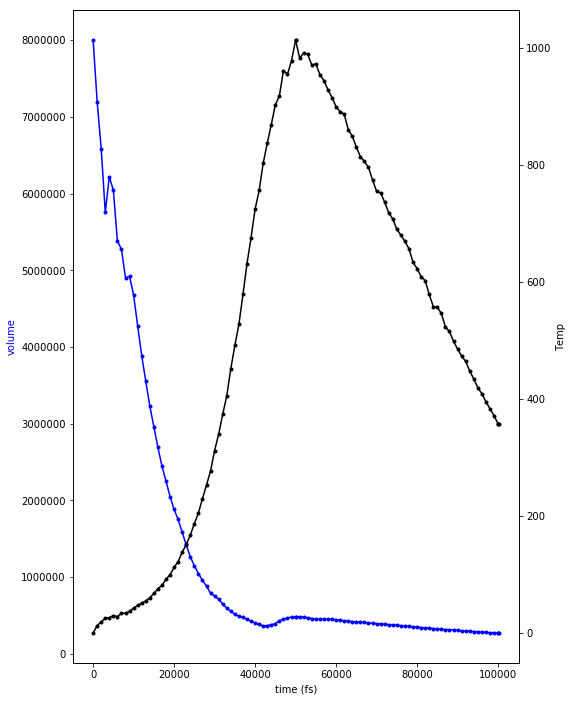

In [424]:

fig, ax = plt.subplots(1,sharey=True)
ax2 = ax.twinx()

for run_i in lmp_i.properties['run_list']:

    ax.plot(run_i.timeseries['step'],run_i.timeseries['volume'],'b.-')

    ax2.plot(run_i.timeseries['step'],run_i.timeseries['temp'],'k.-')
    
ax.set_ylabel('volume', color='b')
ax2.set_ylabel('temp', color='k')
ax.set_xlabel('time (fs)', color='k')


fig.subplots_adjust(hspace=0.0)   
fig.set_size_inches(8.0, 12.0)

fig.savefig('{}.pdf'.format(lmp_i.tag),format='pdf')



Cool the volume is decreasing 

In [425]:
lmp_i.store()

In [426]:
lmp_i.pull()

Read in data file output and update positions

In [428]:
os.chdir(lmp_i.dir['launch'])

In [429]:
datafn = lmp_i.files['output']['data_3']
print datafn

equ0.data


In [509]:
lmp_i.read_data_pos(datafn)

In [510]:
print lmp_i.strucC.lat.matrix

[[ 64.6368559   0.          0.       ]
 [  0.         64.6368559   0.       ]
 [  0.          0.         64.6368559]]


In [432]:
lmp_i.strucC.tag += '_equ0'

In [433]:
lmp_i.strucC.write_xyz()

In [434]:
lmp_i.strucC.calc_center_mass()

Create groups out of the molecules

In [436]:
groupset_i = streamm.Groups('mol',lmp_i.strucC)
groupset_i.group_prop('mol','oligomers')

In [437]:
print len(groupset_i.groups)

50


In [460]:
print groupset_i.strucC.lat.pbcs

[True, True, True]


In [494]:
print groupset_i.strucC.lat.matrix

[[ 64.6368559   0.          0.       ]
 [  0.         64.6368559   0.       ]
 [  0.          0.         64.6368559]]


Apply periodic boundries to all the groups, so the molecules are not split across pbc's

In [512]:
groupset_i.group_pbcs()

In [513]:
groupset_i.strucC.write_xyz('g_pbcs.xyz')

In [ ]:
groupset_i.calc_cent_mass()
groupset_i.calc_radius()
# groupset_i.calc_dl()

Create a neighbor list of groups 

In [541]:
groupset_i.group_nblist.radii_nblist(groupset_i.strucC.lat,groupset_i.cent_mass,groupset_i.radius,radii_buffer=1.00)

In [542]:
for gk_i,g_i in groupset_i.groups.iteritems():
        print g_i, groupset_i.group_nblist.calc_nnab(g_i)



KeyError: u' Neighbor list not set '

Loop over each group, shift the group to the center of the simulation cell and write an .xyz file that includes the neighbors of the group.

In [538]:
for gk_i,g_i in groupset_i.groups.iteritems():
        list_i = groupset_i.groups[gk_i].pkeys
        for g_j in groupset_i.group_nblist.getnbs(gk_i):
            list_i += groupset_i.groups[g_j].pkeys
        groupset_i.strucC.shift_pos(-1.0*g_i.cent_mass)  # Place center of mass at origin
        groupset_i.strucC.write_xyz_list(list_i,xyz_file='nn_{}.xyz'.format(g_i.tag))
        groupset_i.strucC.shift_pos(g_i.cent_mass)  # Return center of mass 

KeyboardInterrupt: 

In [ ]:
The nearest neighbor cluster look good so let us calculate the electron transfer 

In [ ]:
for gk_i,g_i in groupset_i.groups.iteritems():
    for g_j in groupset_i.group_nblist.getnbs(gk_i):
        if( g_j > g_i ):
            

    


Cool looks like we got the box size down a bit, but we will need to run some more to get a solid system

Let's change some of our run parameters for this longer run

In [ ]:
print peregrine.properties.keys()

In [ ]:
peregrine.properties['queue'] = 'batch'
peregrine.properties['nodes'] =  8
peregrine.properties['ppn'] =  24
peregrine.properties['nproc'] =  8*24
peregrine.properties['walltime'] =  48

In [ ]:
p3ht_et = lmp_run(p3ht_et,lmp_i.strucC,oplsaa,peregrine,md_type = 'equ1')

In [ ]:
p3ht_et.check()

In [ ]:
lmp_i = p3ht_et.calculations['lmp_equ1_p3HTx50_equ0'] 

In [ ]:
lmp_i.analysis()

In [ ]:
print len(lmp_i.properties['run_list'])

In [ ]:
lmp_i.store()

In [ ]:
lmp_i.pull()

Read in data file output and update positions

In [ ]:
print lmp_i.dir['launch']
os.chdir(lmp_i.dir['launch'])

In [ ]:
datafn = lmp_i.files['output']['data_3']
print datafn

In [ ]:
lmp_i.read_data_pos(datafn)

In [ ]:
print lmp_i.strucC.lat.matrix

In [ ]:
lmp_i.strucC.write_xyz()

Sweet as bro!